# Brightfield Test
Notebook to demonstrate the use of Safas with brightfield images

In [11]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pickle

import cv2
import numpy as np
from rich import progress
import matplotlib.pyplot as plt

# add safas to PATH
sys.path.append(str(Path().absolute().parents[1])) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from safas.labelers.edge_gradient import labeler 
from safas import data

## Check darkfield image result

In [2]:
src = data.darkfield_highgray_mudflocs()
src = src[400:1000, 400:1000, :] #crop 

In [240]:
# process using two different parameter sets
params = dict(brightfield=False,
            thresh_val=120,
            apply_grad_filter=False,
            grad_thresh_val=80,
            apply_min_px_filter=True,
            area_min_px=5,
            return_thresh=True)

objs_1, thresh, labels = labeler.labeler(src, **params)
title_1 = f"{len(objs_1)} objs, thresh_val {params['thresh_val']}, grad_thresh_val {params['grad_thresh_val']}"
print(title_1)



objs larger than size thresh:
[ 0  1  2  3  4  5  6  7  8  9 11]
11 objs, thresh_val 120, grad_thresh_val 80


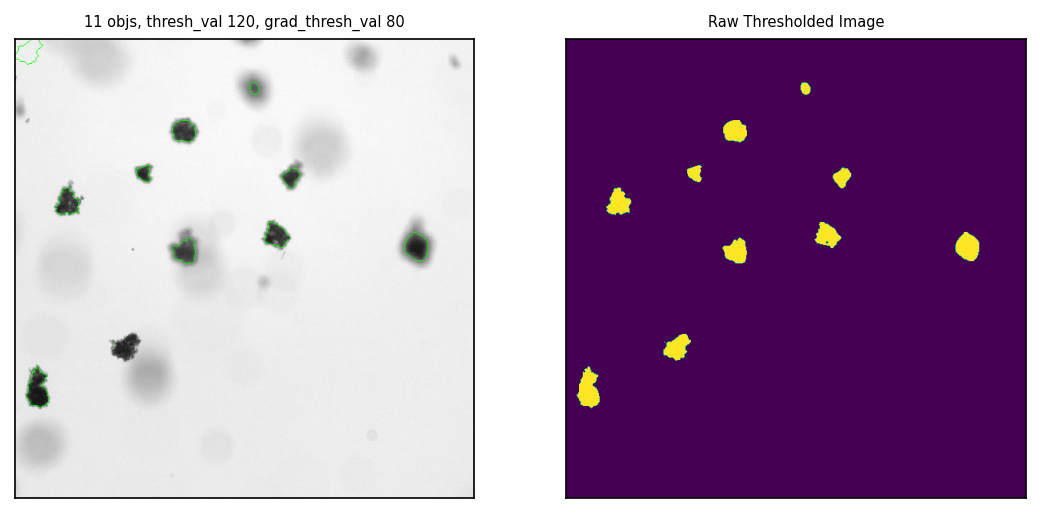

In [242]:
f, ax  = plt.subplots(1,2, dpi=150, figsize=(7.5, 3.5))

for a in ax: 
    a.set_xticks([])
    a.set_yticks([])

def add_cv_contours(out, objs): 
    for obj_idx in list(objs): 
        try: 
            pts = objs[obj_idx]["obj_contour_cv"] 
            out = cv2.drawContours(out, pts, -1, (0,255,0), 1) 
        except IndexError: 
            continue
    return out

out_1 = add_cv_contours(src.copy(), objs_1)

ax[0].imshow(out_1)
ax[0].set_title(title_1, fontsize=7)
ax[1].imshow(thresh)
ax[1].set_title("Raw Thresholded Image", fontsize=7)
plt.tight_layout()

plt.savefig('darkfield_and_thresh.png', dpi=150, facecolor="w")

### Test with brightfield image

In [75]:
filename = r"C:\Users\rmcma\Desktop\2023-09-27 RBINS test images\IMG_7214.JPG"
src = cv2.imread(filename)
print(f"Image size: {src.shape}")

Image size: (4640, 6960, 3)


In [18]:
# crop and transfer a test image to safas.data
output = "../../safas/data/brightfield_flocs.png"
cv2.imwrite(output, src[940:1940, 1500:2500])

True

In [19]:
# test reload from module
src = data.brightfield_flocs()
src.shape

(1000, 1000, 3)

In [76]:
# process using two different parameter sets
params = dict(
    brightfield=True,
    thresh_val=25,
    apply_grad_filter=False,
    grad_thresh_val=80,
    apply_min_px_filter=True,
    area_min_px=50,
    return_thresh=True, 
    return_labels=True
)

objs, thresh, labels = labeler.labeler(src, **params)
title_1 = f"{len(objs)} objs, thresh_val {params['thresh_val']}, grad_thresh_val {params['grad_thresh_val']}"
print(title_1)

373 objs, thresh_val 25, grad_thresh_val 80


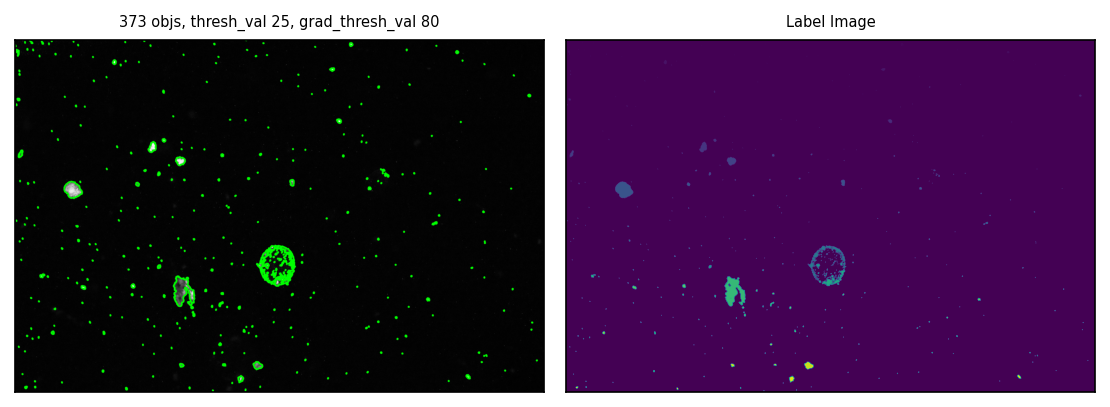

In [77]:
f, ax  = plt.subplots(1,2, dpi=150, figsize=(7.5, 3.5))

for a in ax: 
    a.set_xticks([])
    a.set_yticks([])

def add_cv_contours(out, objs): 
    for i in objs:      
        pts = objs[i]["obj_contour_cv"] 
        out = cv2.drawContours(out, pts, -1, (0,255,0), 20) 
    return out

out = add_cv_contours(src.copy(), objs)

ax[0].imshow(out)
ax[0].set_title(title_1, fontsize=7)
ax[1].imshow(labels)
ax[1].set_title("Label Image", fontsize=7)
plt.tight_layout()

plt.savefig('brightfield_and_thresh.png', dpi=150, facecolor="w")


### Image features: demo with scikit-image
SAFAS uses OpenCV for speed/ efficiency. However, it is often easier to use scikit-image when exploring images or learning. 

In [32]:
thresh = ((labels>0)*255).astype(np.uint8)

In [33]:
# opencv: labels the regions, then need to put in low-level code
# to get the properties you want
_, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)

In [38]:
# scikit-image: a function called regionprops calculates some commonly
# used image features for you
from skimage import measure
props = measure.regionprops(labels)

In [74]:
dir(props[1])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_cache_active',
 '_extra_properties',
 '_image_intensity_double',
 '_intensity_image',
 '_label_image',
 '_multichannel',
 '_ndim',
 '_offset',
 '_pixel_area',
 '_slice',
 '_spacing',
 '_spatial_axes',
 'area',
 'area_bbox',
 'area_convex',
 'area_filled',
 'axis_major_length',
 'axis_minor_length',
 'bbox',
 'centroid',
 'centroid_local',
 'centroid_weighted',
 'centroid_weighted_local',
 'coords',
 'coords_scaled',
 'eccentricity',
 'equivalent_diameter_area',
 'euler_number',
 'extent',
 'feret_diameter_max',
 'image',
 'image_convex',
 'image_filled',
 'image_in

(100, 1000000)

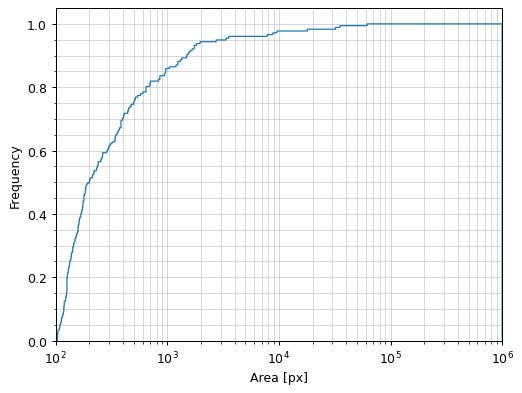

In [70]:
# we can plot the pixel area now like this: 
f, ax = plt.subplots(1,1,dpi=90)
area = [p.area for p in props]
h = ax.hist(area, 
            bins=np.logspace(2, 6, 1000), 
            cumulative=True, 
            density=True,
            histtype="step")
ax.set_xlabel("Area [px]")
ax.set_xscale("log")
ax.set_ylabel("Frequency")
ax.minorticks_on()
ax.grid(which="both", alpha=0.5)
ax.set_xlim(10**2, 10**6)